# Laboratory of Computational Physics
## Final Project - Analysis of Vodafone Users' Fluxes
#### Authors: 
- Simon Barton 
- Philipp Zehetner 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Simon = False
Philipp = True

In [2]:
if Simon : 
    from google.colab import drive
    drive.mount('/content/drive')
    path0 = "/content/drive/My Drive/Uni/Master/Machine Learning Lab/Python Course/Project/Vodafone/Data/"
    path = "/content/drive/My Drive/Uni/Master/Machine Learning Lab/Python Course/Project/Vodafone/Data/"
    
if Philipp : 
    path0='/home/philipp/Studium/LabCourse_ComputationalPhysics/ModulA/Project/Data/'
    path='/home/philipp/Studium/LabCourse_ComputationalPhysics/ModulA/Project/Vodafone/Data/'

### Reading the Data

- __distinct_users_day.csv__: Contains number of users and their origin averaged of weekdays
- __day_od.csv__: Contains the flow of users from one area to another, grouped by their origin and averaged over weekdays and months. 
- __codici_nazioni.csv__: Translates the codes used for different country into their Italian names
- __codici_istat_provincia.csv__: Translates the codes used for different provinces into their Italian names
- __codici_istat_comune.csv__: Translates the codes used for different communities into their Italian names
- __Veneto.txt__: Contains distances (in km and minutes by car) between different Italian cities
- __prov_Pops.csv__: Population of the different provinces. Data obtained from [Wolfram Knowledgebase](http://www.wolfram.com/knowledgebase)

In [3]:
df_Veneto = pd.read_csv(path0+'Veneto.txt',sep=';',decimal=',')
df_Codici_Comune = pd.read_csv(path+'codici_istat_comune.csv',encoding='latin1')
df_Codici_Provincia = pd.read_csv(path+'/codici_istat_provincia.csv', encoding='latin1')
df_Codici_Nazioni = pd.read_csv(path+'codici_nazioni.csv', encoding='utf-16')
df_Day = pd.read_csv(path+'day_od.csv', encoding='utf-16')
df_Distinct_Users = pd.read_csv(path+'distinct_users_day.csv', encoding='latin1')
df_Prov_People = pd.read_csv(path+'provPops.csv', header=None, names=['PRO_CODE', 'POPULATION'])

In [4]:
# Dictionaries often are better to use than data frames
nationNames = dict(zip(df_Codici_Nazioni.COD_COUNTRY,df_Codici_Nazioni.COUNTRY_NAME_IT))
nationNames_r = dict(zip(df_Codici_Nazioni.COUNTRY_NAME_IT, df_Codici_Nazioni.COD_COUNTRY))
ProvinceNames = dict(zip(df_Codici_Provincia.COD_PRO, df_Codici_Provincia.PROVINCIA))
ProvinceNames_r = dict(zip(df_Codici_Provincia.PROVINCIA, df_Codici_Provincia.COD_PRO))
ProvincePop = dict(zip(df_Prov_People.PRO_CODE, df_Prov_People.POPULATION))
CommuneNames = dict(zip(df_Codici_Comune.PRO_COM, df_Codici_Comune.COMUNE))

## 1. Country Ranking

We use the information of users' origin in the _distinct users_ to calculate a ranking of of countries with the most visitors. 


In [5]:
Foreigners = df_Distinct_Users[df_Distinct_Users['CUST_CLASS']=='foreigner']
Foreigners = Foreigners[Foreigners['COD_COUNTRY']!=-999]
Countries = list(df_Codici_Nazioni.COUNTRY_NAME_IT)
CCodes = []
Fluxes = []

for country in Countries: 
    code = nationNames_r[country]
    Flux = Foreigners[Foreigners['COD_COUNTRY']==code].VISITORS.sum()
    if Flux != 0 and code not in CCodes: 
        # United States for some reason appear 5 times in that list with identical values. We remove 4. 
        CCodes.append(code)
        Fluxes.append(Flux)
        
CCodes, Fluxes = zip(*sorted(zip(CCodes, Fluxes), key=lambda x: x[1])[-20:])

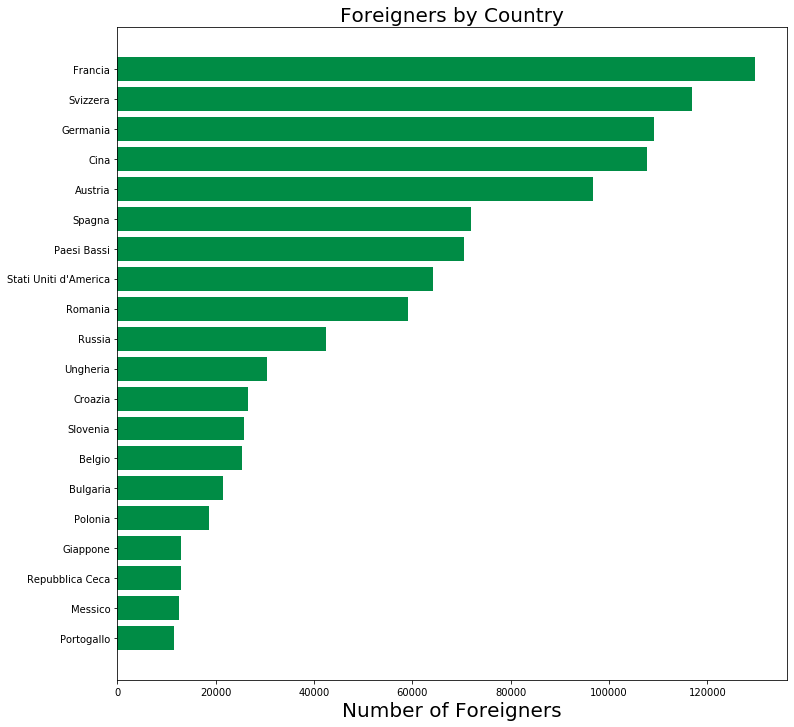

In [6]:
fig, ax = plt.subplots(1,1, figsize=(12,12))

Object = [nationNames[CCodes[i]] for i in range(len(CCodes))]
y_pos = np.arange(len(Object))
plt.barh(y_pos, Fluxes, color='#008C45')
plt.yticks(y_pos, Object)
plt.title("Foreigners by Country", fontsize=20)
plt.xlabel("Number of Foreigners", fontsize=20)
plt.show()

## 2. Province Ranking

We use the same file _distinct Users_ to rank Italian users by their origin, but normalize it to the population of their origin. 

In [7]:
Visitors = df_Distinct_Users[df_Distinct_Users['CUST_CLASS']=='visitor']
provinces = list(df_Codici_Provincia.PROVINCIA)
PCodes = []
Fluxes = []

for province in provinces: 
    code = ProvinceNames_r[province]
    Flux = Visitors[Visitors['COD_PRO']==code].VISITORS.sum()
    if Flux != 0 : 
        PCodes.append(code)
        Fluxes.append(Flux)
        
NFluxes = [0]*len(Fluxes)

for i in range(len(Fluxes)): 
    NFluxes[i] = Fluxes[i]/ProvincePop[PCodes[i]]
        
NPCodes, NFluxes = zip(*sorted(zip(PCodes, NFluxes), key=lambda x: x[1])[-20:])
PCodes, Fluxes = zip(*sorted(zip(PCodes, Fluxes), key=lambda x: x[1])[-20:])

provinces = []
for c in PCodes : 
    provinces.append(ProvinceNames[c])

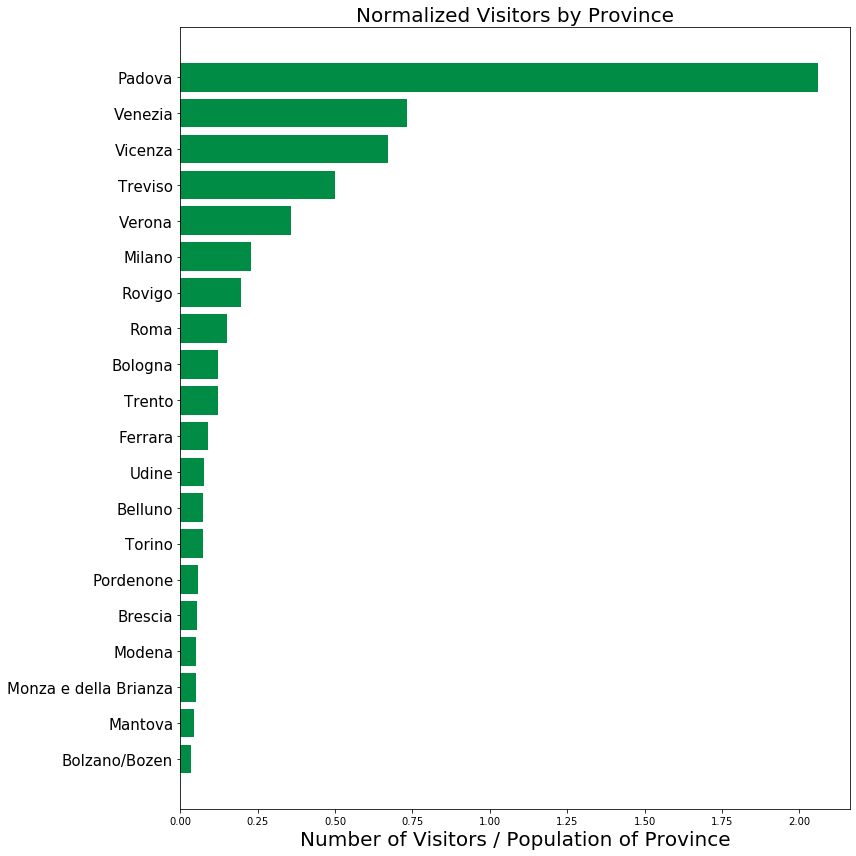

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,12))

Object = [ProvinceNames[PCodes[i]] for i in range(len(PCodes))]
y_pos = np.arange(len(Object))
plt.barh(y_pos, NFluxes, color='#008C45')
plt.yticks(y_pos, Object, fontsize=15)
plt.title("Normalized Visitors by Province", fontsize=20)
plt.xlabel("Number of Visitors / Population of Province", fontsize=20)
fig.tight_layout()
fig.show()

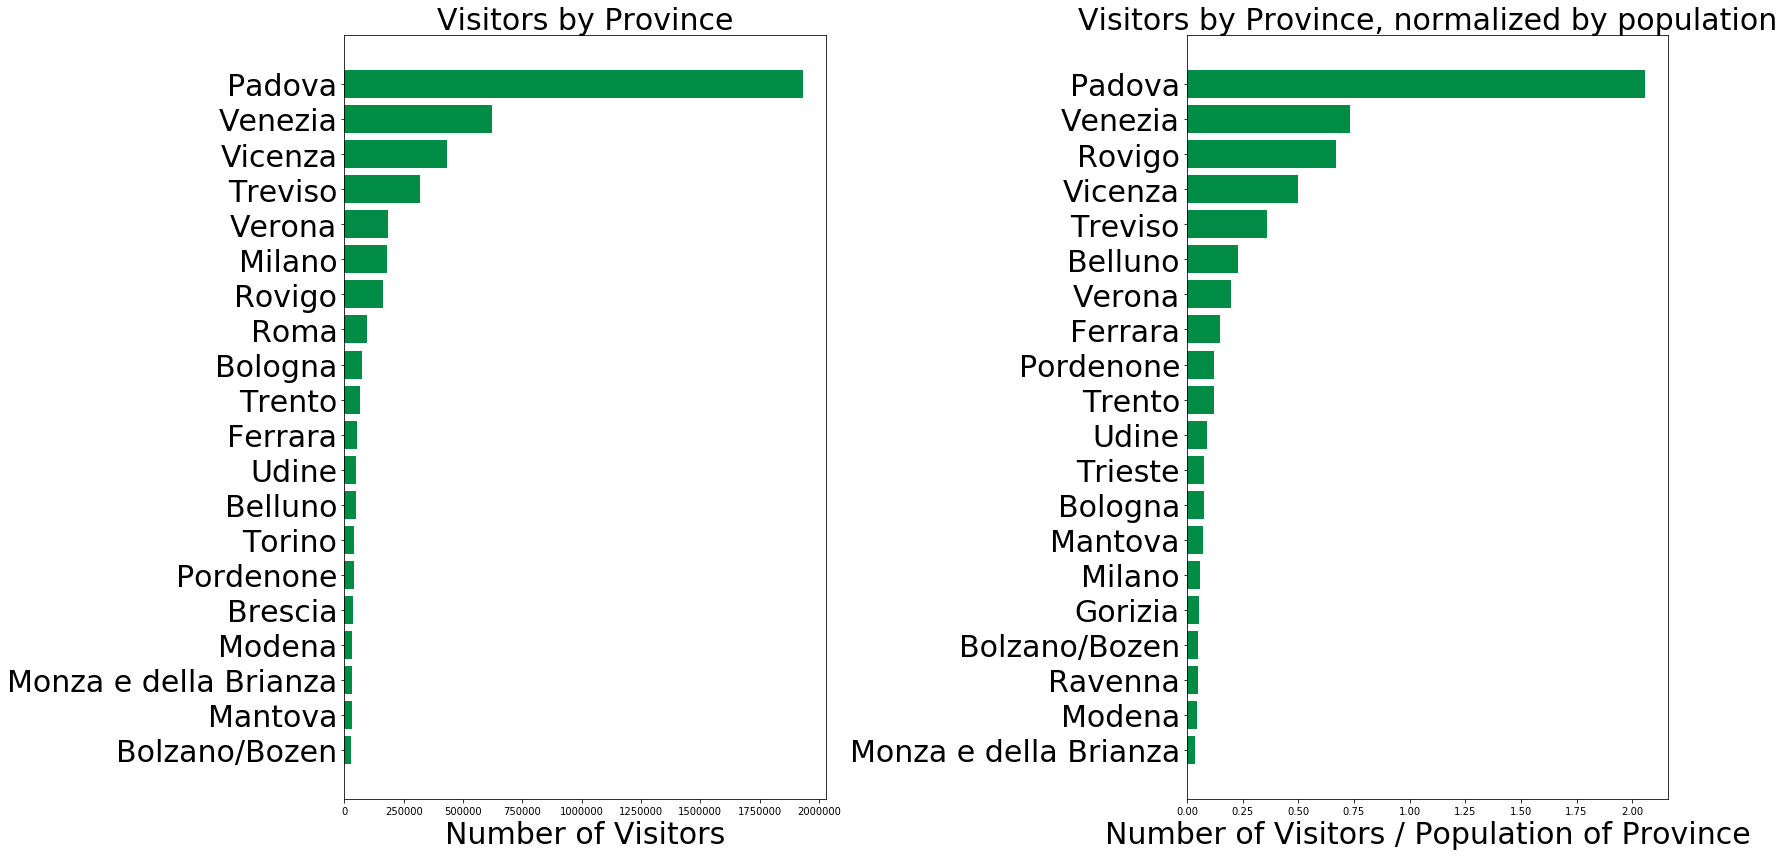

In [24]:
fig, ax = plt.subplots(1,2, figsize=(24,12))

Object0 = [ProvinceNames[PCodes[i]] for i in range(len(PCodes))]
Object1 = [ProvinceNames[NPCodes[i]] for i in range(len(PCodes))]

y_pos = np.arange(len(Object))
ax[0].barh(y_pos, Fluxes, color='#008C45')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(Object0, fontsize=30)
ax[0].set_title("Visitors by Province", fontsize=30)
ax[0].set_xlabel("Number of Visitors", fontsize=30)

ax[1].barh(y_pos, NFluxes, color='#008C45')
ax[1].set_title("Visitors by Province, normalized by population", fontsize=30)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(Object1, fontsize=30)
ax[1].set_xlabel("Number of Visitors / Population of Province", fontsize=30)


fig.tight_layout()
fig.show()

## 3. Correlation between Distance and Number of Visitors

In [10]:
Ven = df_Veneto[df_Veneto['Destinazione']==28060]
D_min = 0
D_max = 1300
D_step = 100
Distances = np.arange(D_min, D_max, D_step)
len(Distances)
# Create a List with the comune whose distances fits with the Distances range. 

Com_Dist = []
for i in Distances : 
    d_low = i * 1000
    d_high = i * 1000 + D_step * 1000
    Temp = Ven[Ven['Total_Mete'] >= d_low]
    Temp = Temp[Temp['Total_Mete'] < d_high]
    Coms = list(Temp['Origine'])
    Com_Dist.append(Coms)
    
D_Visitors = []
for c in Com_Dist : 
    v = 0
    for cc in c :      
        if cc in CommuneNames.keys() : 
            v += sum(df_Day[df_Day["PRO_COM"]==cc].FLOW)
    D_Visitors.append(v)
    
N_Communes = [len(Com_Dist[i]) for i in range(len(Distances)) ]

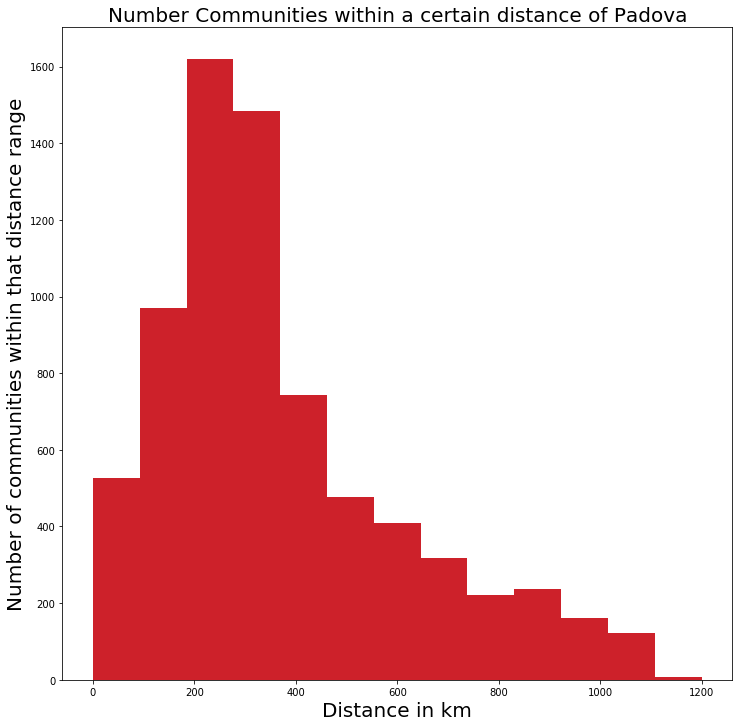

In [11]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.hist(Distances, len(Distances), weights=np.array(N_Communes), color='#CD212A')
ax.set_xlabel("Distance in km", fontsize=20)
ax.set_ylabel("Number of communities within that distance range", fontsize=20)
ax.set_title("Number Communities within a certain distance of Padova", fontsize=20)
fig.show()

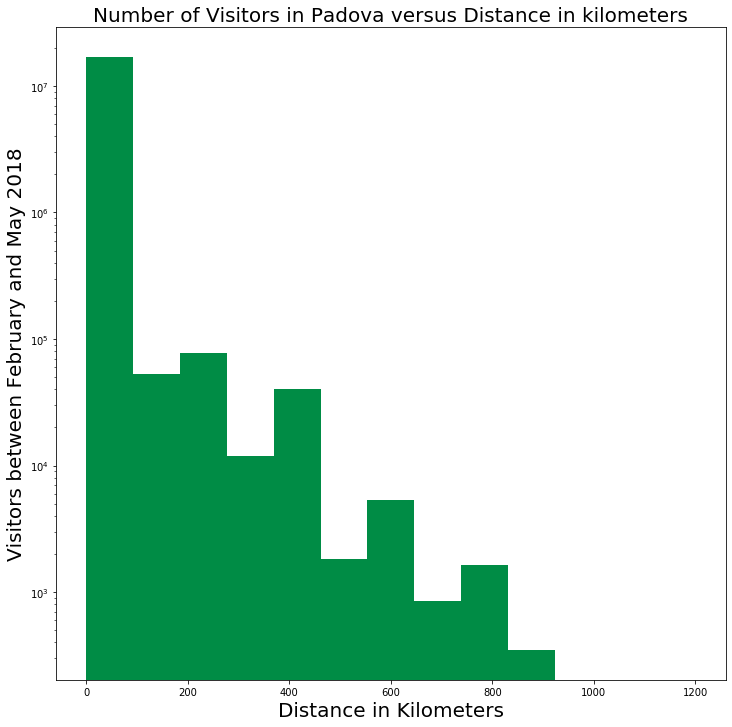

In [12]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
n, bins, patches = ax.hist(Distances, len(Distances), weights=D_Visitors, log=True, color='#008C45')
ax.set_title("Number of Visitors in Padova versus Distance in kilometers", fontsize=20)
ax.set_xlabel("Distance in Kilometers", fontsize=20)
ax.set_ylabel("Visitors between February and May 2018", fontsize=20)
ax.set_yscale('log')

plt.show()

## 4. Highway to Padova

The Origin and Destination in our data is coded with three digits. We don't know which areas these codes represent, but have been told that _1xx_ corresponds to areas in the inner city, _2xx_ to areas a bit further outside and _300_ the wider Padova province area

In [13]:
WeekDays = ['Lunedì', 'Martedì', 'Mercoledì', 'Giovedì', 'Venerdì']
WeekEnd = ['Sabato', 'Domenica']

In [14]:
Commuters = df_Day[df_Day['CUST_CLASS']!='foreigner']
Commuters = Commuters[Commuters['PRO_COM']!=-999]

Commuters_WD = pd.concat([Commuters[Commuters['DOW']== d] for d in WeekDays])
Commuters_WE = pd.concat([Commuters[Commuters['DOW']== d] for d in WeekEnd])

Commuters21 = Commuters[Commuters['ORIGIN']/100 >=2]
Commuters21 = Commuters21[Commuters21['ORIGIN']/100<3]
Commuters21 = Commuters21[Commuters21['DESTINATION']/100<2]
Commuters21_WD = pd.concat([Commuters21[Commuters21['DOW']== d] for d in WeekDays])
Commuters21_WE = pd.concat([Commuters21[Commuters21['DOW']== d] for d in WeekEnd])

Commuters12 = Commuters[Commuters['ORIGIN']/100<2]
Commuters12 = Commuters12[Commuters12['DESTINATION']/100<3]
Commuters12 = Commuters12[Commuters12['DESTINATION']/100>=2]
Commuters12_WD = pd.concat([Commuters12[Commuters12['DOW']== d] for d in WeekDays])
Commuters12_WE = pd.concat([Commuters12[Commuters12['DOW']== d] for d in WeekEnd])

Commuters31 = Commuters[Commuters['ORIGIN']/100>=3]
Commuters31 = Commuters31[Commuters31['DESTINATION']/100<2]
Commuters31_WD = pd.concat([Commuters31[Commuters31['DOW']== d] for d in WeekDays])
Commuters31_WE = pd.concat([Commuters31[Commuters31['DOW']== d] for d in WeekEnd])

Commuters13 = Commuters[Commuters['ORIGIN']/100<2]
Commuters13 = Commuters13[Commuters13['DESTINATION']/100>=3]
Commuters13_WD = pd.concat([Commuters13[Commuters13['DOW']== d] for d in WeekDays])
Commuters13_WE = pd.concat([Commuters13[Commuters13['DOW']== d] for d in WeekEnd])


#These can be ignored, as no flow between these areas exists
Commuters32 = Commuters[Commuters['ORIGIN']/100>=3]
Commuters32 = Commuters32[Commuters32['DESTINATION']/100>=2]
Commuters32 = Commuters32[Commuters32['DESTINATION']/100<3]
Commuters32_WD = pd.concat([Commuters32[Commuters32['DOW']== d] for d in WeekDays])
Commuters32_WE = pd.concat([Commuters32[Commuters32['DOW']== d] for d in WeekEnd])

#These can be ignored, as no flow between these areas exists
Commuters23 = Commuters[Commuters['ORIGIN']/100>=2]
Commuters23 = Commuters23[Commuters23['ORIGIN']/100<3]
Commuters23 = Commuters23[Commuters23['DESTINATION']/100>=3]
Commuters23_WD = pd.concat([Commuters23[Commuters23['DOW']== d] for d in WeekDays])
Commuters23_WE = pd.concat([Commuters23[Commuters23['DOW']== d] for d in WeekEnd])

Sum_WD = Commuters_WD.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
Sum_WE = Commuters_WE.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
d_WD = dict(zip(Sum_WD['PRO_COM'],Sum_WD['FLOW']))
d_WE = dict(zip(Sum_WE['PRO_COM'],Sum_WE['FLOW']))
Sum_12_WD = Commuters12_WD.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
Sum_12_WE = Commuters12_WE.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
Sum_21_WD = Commuters21_WD.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
Sum_21_WE = Commuters21_WE.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
Sum_13_WD = Commuters13_WD.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
Sum_13_WE = Commuters13_WE.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
Sum_31_WD = Commuters31_WD.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
Sum_31_WE = Commuters31_WE.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
#These can be ignored, as no flow between these areas exists
Sum_23_WD = Commuters23_WD.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
Sum_23_WE = Commuters23_WE.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
Sum_32_WD = Commuters32_WD.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])
Sum_32_WE = Commuters32_WE.groupby('PRO_COM')['FLOW'].agg(np.sum).reset_index(level=['PRO_COM'])

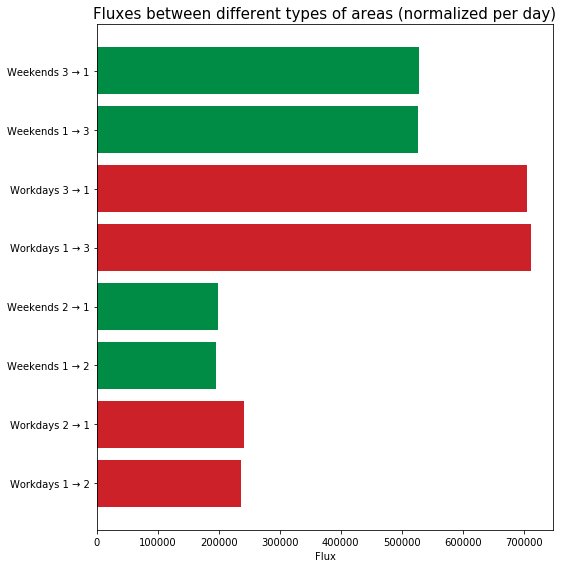

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
Labels = ["Workdays 1 \u2192 2", "Workdays 2 \u2192 1", "Weekends 1 \u2192 2", "Weekends 2 \u2192 1",
          "Workdays 1 \u2192 3", "Workdays 3 \u2192 1", "Weekends 1 \u2192 3", "Weekends 3 \u2192 1"]
Heights = [Sum_12_WD['FLOW'].sum()/5, Sum_21_WD['FLOW'].sum()/5, Sum_12_WE['FLOW'].sum()/2, Sum_21_WE['FLOW'].sum()/2,
           Sum_13_WD['FLOW'].sum()/5, Sum_31_WD['FLOW'].sum()/5, Sum_13_WE['FLOW'].sum()/2, Sum_31_WE['FLOW'].sum()/2]
y_pos = np.arange(len(Labels))
colors = ['#CD212A', '#CD212A', '#008C45', '#008C45', '#CD212A', '#CD212A', '#008C45', '#008C45']
plt.barh(y_pos, Heights, color=colors)
plt.yticks(y_pos, Labels)
plt.title("Fluxes between different types of areas (normalized per day)", fontsize=15)
plt.xlabel("Flux")
fig.tight_layout()
plt.show()

In [16]:
print("Workdays 1 \u2192 2:", Sum_12_WD['FLOW'].sum()/5)
print("Workdays 2 \u2192 1:", Sum_21_WD['FLOW'].sum()/5)
print("Weekends 1 \u2192 2:", Sum_12_WE['FLOW'].sum()/2)
print("Weekends 2 \u2192 1:", Sum_21_WE['FLOW'].sum()/2)
print("Workdays 1 \u2192 3:", Sum_13_WD['FLOW'].sum()/5)
print("Workdays 3 \u2192 1:", Sum_31_WD['FLOW'].sum()/5)
print("Weekends 1 \u2192 3:", Sum_13_WE['FLOW'].sum()/2)
print("Weekends 3 \u2192 1:", Sum_31_WE['FLOW'].sum()/2)
print("Workday/Weekend Weekends 1 \u27f7 3:", 0.5*((Sum_13_WD['FLOW'].sum()/5) / (Sum_13_WE['FLOW'].sum()/2) + (Sum_31_WD['FLOW'].sum()/5) / (Sum_31_WE['FLOW'].sum()/2)))
print("Workday/Weekend Weekends 1 \u27f7 2:", 0.5*((Sum_12_WD['FLOW'].sum()/5) / (Sum_12_WE['FLOW'].sum()/2) + (Sum_21_WD['FLOW'].sum()/5) / (Sum_21_WE['FLOW'].sum()/2)))

Workdays 1 → 2: 236558.0
Workdays 2 → 1: 241513.6
Weekends 1 → 2: 195503.5
Weekends 2 → 1: 198942.5
Workdays 1 → 3: 712765.6
Workdays 3 → 1: 706055.8
Weekends 1 → 3: 526326.5
Weekends 3 → 1: 529026.5
Workday/Weekend Weekends 1 ⟷ 3: 1.3444296392713722
Workday/Weekend Weekends 1 ⟷ 2: 1.2119903195037756


From this plot, we note a couple of things: 

- We suspect that _300_ refers to the center of Padova instead of the wider Padova province area as no flux from the areas _2xx_ to _300_ is observed. 
- Some kind of continuity equation holds for Vodafone around Padova and possibly for humans in general as the flux from _1xx_ or _2xx_ to _300_ is roughly equivalent to the flux from _300_ to _1xx_ or _2xx_
- Weekends are less busy than Workdays
- The relative difference between weekends and workdays is less pronounced when travveling between _1xx_ and _2xx_ (factor 1.21) as it is between _1xx_ and _300_ (factor 1.34)

### Flux per Highway

Around Padova we can define three major directions. 
- West on _Autostrada Serenissima_ to Verona
- East on _Autostrada Serenissima_ to Venezia
- South on _Autostrada Bologna-Padova_ to Bologna

We use the [Google Directions API](https://developers.google.com/maps/documentation/directions/start) to download the driving instructions from all Communities to Padova as .json files (in a separate notebook) and parse the routes for keywords indicating if they are using any and which of the three highways. The instructions were queried without traffic information to keep them as general as possible and not make them avoid highways.

![Padova](Padova_Map.png)

In [17]:
import glob, os
import json

routeFiles = glob.glob(os.path.join(path+'Routes/*.json'))

def getDest(filename):
  return filename[filename.rfind('/')+1:-5]

def hasStep(steps, q):
  return q in [s["html_instructions"] for s in steps]

def hasTerm(steps, q):
  return q in "".join([s["html_instructions"] for s in steps])

In [18]:
with open(path+'namedict.json') as nd:
  commIDs = json.load(nd)

west_cs, east_cs, south_cs, other_cs = [], [], [], []
nw,ne,ns,no=0,0,0,0
flow_we_west, flow_we_east, flow_we_south, flow_we_other = 0,0,0,0
flow_wd_west, flow_wd_east, flow_wd_south, flow_wd_other = 0,0,0,0
pw,pe,ps,po=0,0,0,0
for fn in routeFiles: 
    with open(fn, 'r') as f: 
        basename = "Italy+"+fn[fn.rfind('/')+1:fn.rfind('.')]
        directions = json.load(f)
        route = directions['routes'][0]
        leg = route['legs'][0]
        steps = directions['routes'][0]['legs'][0]['steps']
        
        # Check indication for each highway:
        west = hasTerm(steps,"E70") and hasStep(steps,"Take exit <b>Padova Est</b> toward <b>Padova Est</b>");
        east = hasTerm(steps,"E70") and hasStep(steps,"Take exit <b>Padova Est</b> toward <b>Padova Est</b>/<b>Padova Centro</b>");
        south = hasTerm(steps,"A13");
        
        # Add to corresponding list
        if west:
            nw += 1
            west_cs.append(CommuneNames[commIDs[basename]])
            if commIDs[basename] in d_WD.keys() : flow_wd_west += d_WD[commIDs[basename]]
            if commIDs[basename] in d_WE.keys() : flow_we_west += d_WE[commIDs[basename]]
        elif east:
            ne += 1
            east_cs.append(CommuneNames[commIDs[basename]])
            if commIDs[basename] in d_WD.keys() : flow_wd_east += d_WD[commIDs[basename]]
            if commIDs[basename] in d_WE.keys() : flow_we_east += d_WE[commIDs[basename]]
        elif south:
            ns += 1
            south_cs.append(CommuneNames[commIDs[basename]])
            if commIDs[basename] in d_WD.keys() : flow_wd_south += d_WD[commIDs[basename]]
            if commIDs[basename] in d_WE.keys() : flow_we_south += d_WE[commIDs[basename]]
        else:
            no += 1
            other_cs.append(CommuneNames[commIDs[basename]])
            if commIDs[basename] in d_WD.keys() : flow_wd_other += d_WD[commIDs[basename]]
            if commIDs[basename] in d_WE.keys() : flow_we_other += d_WE[commIDs[basename]]
        if (west and east) or (east and south) or (west and south):
            #print("ALARM!")
            pass
        #print(i,len(routeFiles))
        
flow_west = flow_wd_west + flow_we_west
flow_east = flow_wd_east + flow_we_east
flow_south = flow_wd_south + flow_we_south
flow_other = flow_wd_other + flow_we_other

In [19]:
print(flow_we_west/2)
print(flow_wd_west/5)
print(flow_we_east/2)
print(flow_wd_east/5)
print(flow_we_south/2)
print(flow_wd_south/5)
print(flow_we_other/2)
print(flow_wd_other/5)

21101.5
38699.2
30785.0
63471.6
36641.0
61857.4
477408.0
695418.0


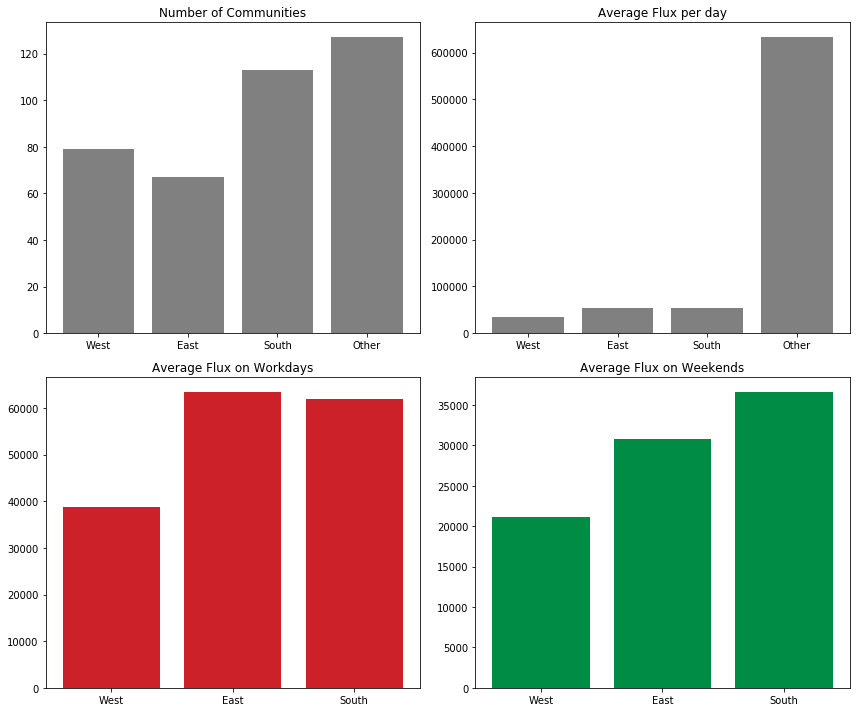

In [20]:
fig,ax = plt.subplots(2,2,figsize=(12, 10))
ax[0][0].bar(range(4), [nw,ne,ns,no], tick_label=["West","East","South","Other"], color='gray')
ax[0][0].title.set_text('Number of Communities')

ax[0][1].bar(range(4),[flow_west/7,flow_east/7,flow_south/7,flow_other/7], tick_label=["West","East","South","Other"],
             color='gray')
ax[0][1].title.set_text('Average Flux per day')

ax[1][0].bar(range(3), [flow_wd_west/5, flow_wd_east/5, flow_wd_south/5], tick_label=["West","East","South"],
             color='#CD212A')
ax[1][0].title.set_text('Average Flux on Workdays')

ax[1][1].bar(range(3), [flow_we_west/2, flow_we_east/2, flow_we_south/2], tick_label=["West","East","South"],
             color='#008C45')
ax[1][1].title.set_text('Average Flux on Weekends')

fig.tight_layout()

By far the largest flux comes from communities very close to Padova, where no highway is needed and not recommended as fastest route by _Google Maps_. When only focusing on the highways a big difference between Weekends and Workdays can be noticed. 

On Workdays the highways from east and south are equally important with roughly 50% more flux than the highway from the west. On Weekends the average flux increases, but in very different manners: 
- In the west the increase is about 25% from around 40k to 50k
- In the east the increase in about a factor of 6 from 63k to 253k
- In the south the increase is more than a factor of 12 from 62k to 862k

## Graphing the Areas to Order them

We are not given the information which areas correspond to which codes, but we expect neighbouring areas to have larger fluxes. Here we try to model Padova using a graph in python with the fluxes as weights for the edges. 

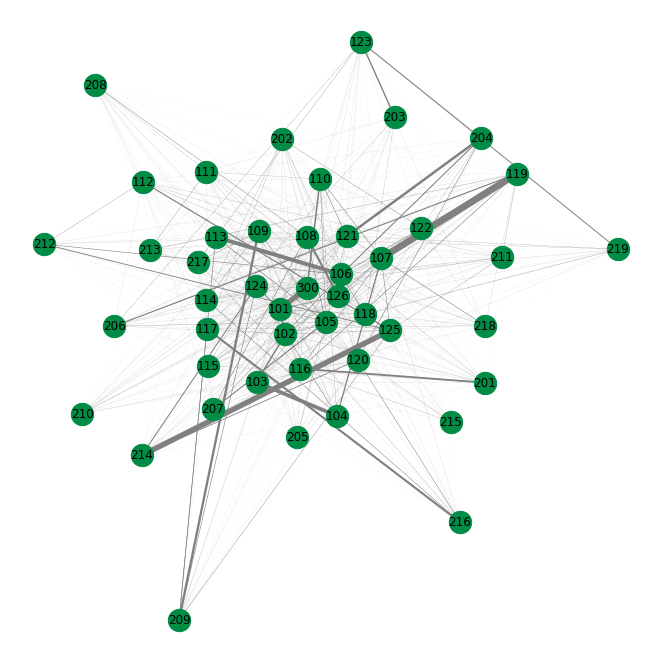

In [21]:
u_origin = sorted(list(df_Day.ORIGIN.unique()))
u_dest = sorted(list(df_Day.DESTINATION.unique()))
u_dest = list(filter(lambda a: a!=-999, u_dest))

if (u_origin == u_dest) : areas = u_origin
else : print('Something went wrong')
    
Area_Flow = df_Day[df_Day['DESTINATION']!=-999].groupby(['ORIGIN','DESTINATION'])['FLOW'].sum()


Area_Flow = Area_Flow.to_frame()
Area_Flow = Area_Flow.reset_index(level=['ORIGIN','DESTINATION'])

Graph = nx.from_pandas_edgelist(Area_Flow, 'ORIGIN', 'DESTINATION', edge_attr=True,
                                create_using=nx.path_graph(100))
plt.figure(figsize=(9,9))
nx.draw(Graph, with_labels=True, edge_color='grey', node_color='#008C45',
        node_size=500, width=Area_Flow['FLOW']/1e5,
        pos=nx.spring_layout(Graph, k=50,weight='FLOW', iterations=1000))


![graph](graph_8.svg)